# A History of Dual Citizenships

To what extent has countries allowed dual citizenships and how has it changed? What unique characteristics can we glean from the countries allowing or disallowing dual citizenship schemes?   
  
The MACIMIDE Global Expatriate Dual Citizenship Dataset compiled the dual citizenship rules that existed in near all sovereign states of the world for the past half a centry. It contains country names, 3-letter ISO codes and describes 3 policy frameworks: 
* No dual citizenship: acquicing another citizenship leads to automatical renounciation of the original citizenship
* Not automacally renounced: One gets to keep original citizenship, but also have the possibility to voluntarily renounce their citizenship of origin.
* Dual citizenship: One gets to keep original citizenship, and couldn't renounce it.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from ipywidgets import interact, interactive
plt.style.use('fivethirtyeight')
%matplotlib inline

## Pre-processing

In [2]:
df_raw = pd.read_csv("multiple_citizenship_data/dual_citizenship.csv")
print(df_raw.shape)
df_raw.head()

(11800, 13)


,caseid,ISO3,ISO2,country,country_code,dependency_code,world_region,longitude,latitude,Year,Dualcit_cat,Dualcit_grouped,Dualcit_binary
0,1,AFG,AF,Afghanistan,4,NaN,2.0,691761.0,345228.0,1960,210,2,2
1,2,AFG,AF,Afghanistan,4,NaN,2.0,691761.0,345228.0,1961,210,2,2
2,3,AFG,AF,Afghanistan,4,NaN,2.0,691761.0,345228.0,1962,210,2,2
3,4,AFG,AF,Afghanistan,4,NaN,2.0,691761.0,345228.0,1963,210,2,2
4,5,AFG,AF,Afghanistan,4,NaN,2.0,691761.0,345228.0,1964,210,2,2


In [3]:
df = df_raw
df['region']=df.world_region.replace(1.0,'Africa') \
    .replace(2.0,'Asia') \
    .replace(3.0,'Europe') \
    .replace(4.0,'LTAM') \
    .replace(5.0,'North America') \
    .replace(6.0,'Oceania') 

In [4]:
def category (code):
   #based on data codebook
    if (code in [110,111,112]):
        return 'No dual citizenship'
    elif code in [210,211,212,220]:
        return 'Not automatically renounced'
    elif code in [310,320,330]:
        return 'Dual citizenship'
    else:
        return 'Other'
    
df['category']=df_raw['Dualcit_cat'].map(category)

In [5]:
#number of unique countries by continents
print(df.groupby('region')['country'].nunique())

#example countries
unique_cntry = df.groupby('region')['country'].unique()
unique_cntry

region
Africa           54
Asia             48
Europe           49
LTAM             33
North America     2
Oceania          14
Name: country, dtype: int64


region
Africa           [Algeria, Angola, Benin, Botswana, Burkina Fas...
Asia             [Afghanistan, Armenia, Azerbaijan, Bahrain, Ba...
Europe           [Albania, Andorra, Austria, Belarus, Belgium, ...
LTAM             [Antigua and Barbuda, Argentina, Bahamas, Barb...
North America                   [Canada, United States of America]
Oceania          [Australia, Fiji, Kiribati, Marshall Islands, ...
Name: country, dtype: object

## Data cleaning

In [6]:
#remove countries with no info
df=df.query('category!="Other"')

For the countries missing dual citizenship data, we'll remove them as they add no extra information, and there is no way to impute them besides manually gathering info which is beyond the scope of this analysis.

In [7]:
#check for missing value
df.isnull().sum()

caseid                0
ISO3                  0
ISO2                 28
country               0
country_code          0
dependency_code    5481
world_region        143
longitude             0
latitude              0
Year                  0
Dualcit_cat           0
Dualcit_grouped       0
Dualcit_binary        0
region              143
category              0
dtype: int64

In [8]:
# see which countries are missing region
cnty_wo_region=df.loc[pd.isna(df.region),'country'].unique()
cnty_wo_region

array(['Czechoslovakia', 'German Democratic Republic',
       'Serbia and Montenegro', 'Soviet Union', 'Yugoslavia'], dtype=object)

These countries no longer exist today. Let's filter them out.

In [9]:
df=df[~df['country'].isin(cnty_wo_region)]

#final countries remained
df['country'].nunique()

195

In [10]:
#years covered
np.min(df.Year),np.max(df.Year)

(1960, 2018)

We have quite a comprehensive list of 195 countries spanning from 1960 to 2018, all having information on whether they allow dual citizenship, after removing the 5 countries missing region definition since they no longer exist. 

Some were missing ISO2 code or dependency code describing their subdivision, which are of no importance to this analysis.

Also worth noting, some organizations such as Quartz.com reports the 'no automatic renounciation' grouped under 'dual citizenship allowed'. Strickly speaking, it shouldn't be. This is a broad and grey category best treated on its own. For example, Canada and Singapore are both in this category, but Canadians can process multiple passports while in Singapore it is only possible up to 18 years old and by constitution dual citizenship is not allowed. For the accuracy of the analysis, we'll keep the policy in 3 categories instead of 2 categories which would otherwise result in misleadingly high numbers.   
There are also situations where a country only allow dual citizenships with certain other countries which is beyond this dataset.   
In addition, it might also be useful to alert to the fact that the dataset was a manual collection based on many different legislative documents and data quality cannot be inspected solely by looking at distributions.

## Latest state of the policy

In [11]:
### Percentage of countries allowing dual citizenship
df["value"]=1
df2018=df[df['Year']==2018]
df_smry=df2018.pivot_table(index='region',columns='category',values="value",aggfunc='count', fill_value=0, margins=True)
df_smry

category,Dual citizenship,No dual citizenship,Not automatically renounced,All
region,,,,
Africa,4,17,33,54
Asia,2,17,29,48
Europe,1,10,33,44
LTAM,11,3,19,33
North America,0,0,2,2
Oceania,1,2,11,14
All,19,49,127,195


In [12]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#select only the relevant columns
cols = ['country', 'ISO3', 'longitude','latitude','category','Year']
df_s=df2018[cols]
df_s.head()

#join world to data
merged18=world.merge(df_s, left_on='iso_a3',right_on='ISO3',how='inner')

## The history of the policy

### Percentage of countries by category globally

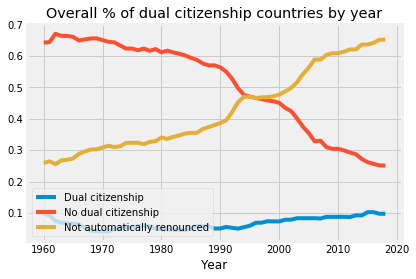

In [13]:
df_smry = df.pivot_table(index=['Year'],columns='category', \
               values="value",aggfunc='count', fill_value=0, margins=1)
df_smry_pct = df_smry.div(df_smry["All"], axis='index')
df_smry_pct.iloc[:-1,:-1].plot()
plt.legend(loc='lower left')
plt.title('Overall % of dual citizenship countries by year')

### Percentage of countries strickly forbid dual citizenship by region

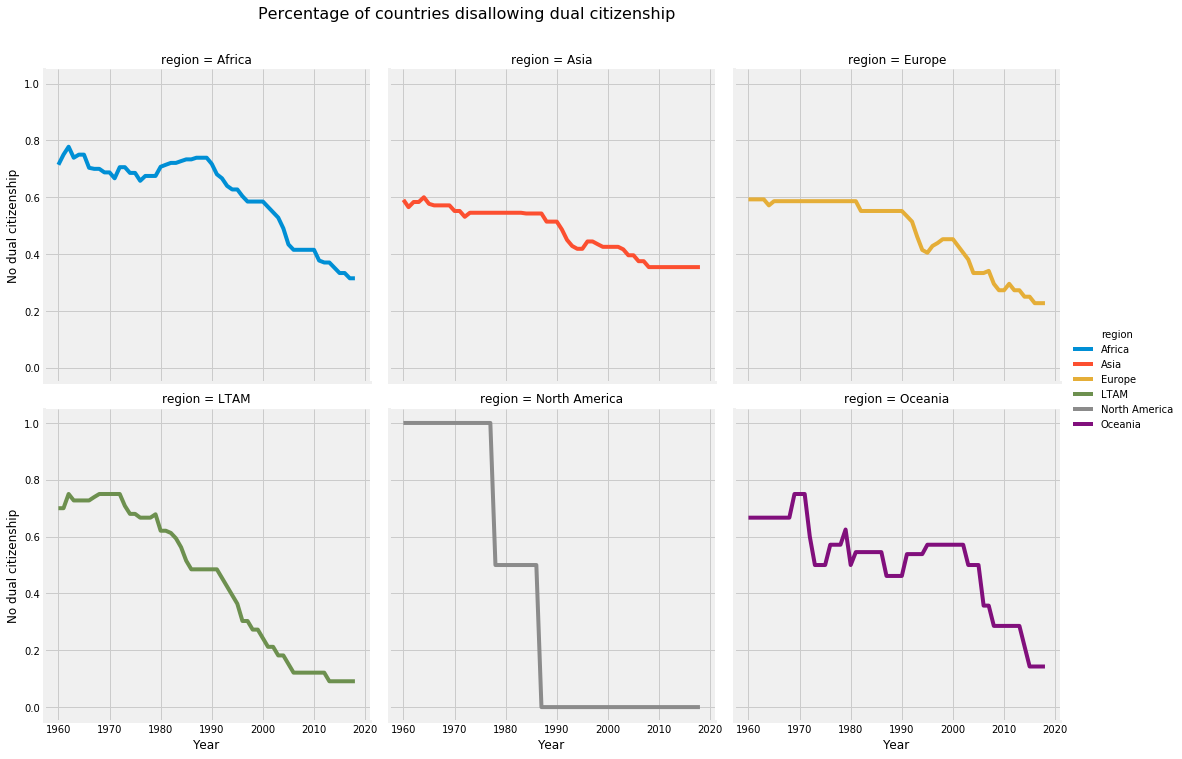

In [14]:
df_smry_yr = df.pivot_table(index=['Year','region'],columns='category', \
               values="value",aggfunc='count', fill_value=0, margins=1)
df_smry_yr_pct = df_smry_yr.div(df_smry_yr["All"], axis='index')
#Countries with strickly no dual citizenship by region
df_region = df_smry_yr_pct.reset_index().iloc[:-1,[0,1,3]]
#small multiples
g=sns.relplot(x='Year', y= 'No dual citizenship', hue="region", col="region", \
            kind="line", col_wrap=3,data=df_region, legend='brief')
g.fig.suptitle('Percentage of countries disallowing dual citizenship', x=0.4, y=1.05,size=16)

### Number of countries by category in each region

In [15]:
regional_agg = df.loc[:,['region','Year','category']].groupby(['region','Year','category']).size(). \
to_frame('count').reset_index()

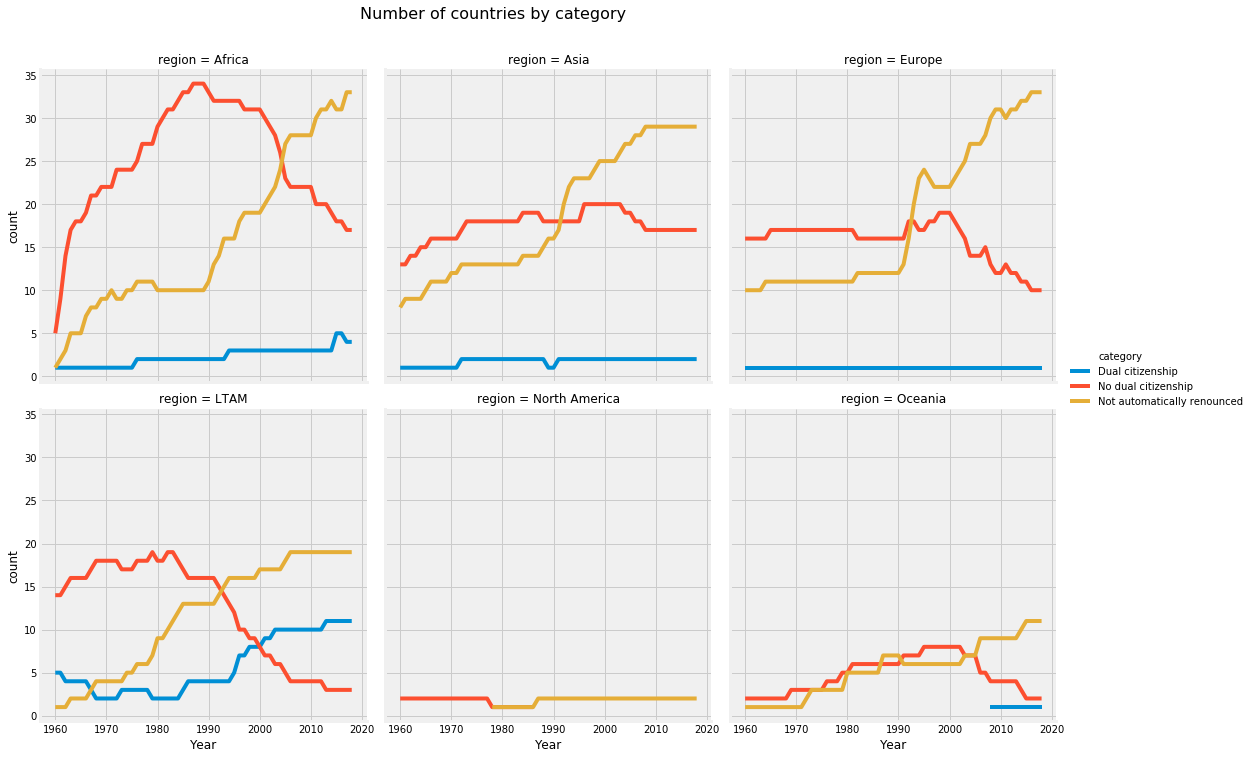

In [16]:
g=sns.relplot(x='Year', y= 'count', hue="category", col="region", kind="line", col_wrap=3,\
            data=regional_agg, legend='brief')
g.fig.suptitle('Number of countries by category', x=0.4, y=1.05,size=16)

Percentage of countries forbiding dual citizenship are on the decline across all regions, though much more gradual in Asia.

Unsuspectingly, Asia has the lowest percentage of countries allowing dual citizenship, even lower than Africa. The 2 countries in North America both allow it and more than 80% of countries in Latin America/Oceania allow it too.

In [17]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#30a2da", \
    "#fc4f30", \
    "#e5ae38"], name='prime')

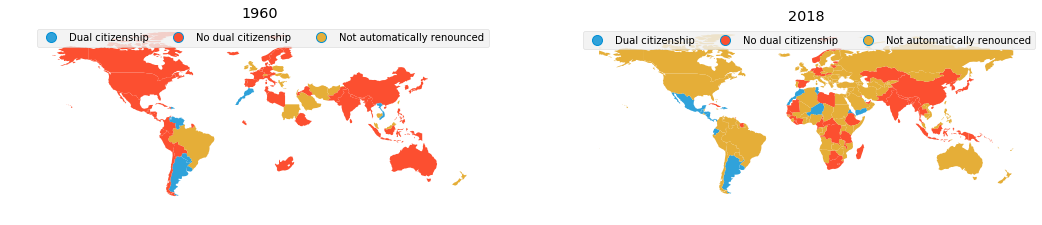

In [18]:
#plot on map
#1960
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,figsize=(16, 4))
#fig, ax = plt.subplots(1, figsize=(8, 6))
ax1.axis('off')
merged=world.merge(df[df['Year']==1960][cols], left_on='iso_a3',right_on='ISO3',how='inner')
merged.head()
lgnd_kwds = {'loc': 'upper left', 'ncol': 3}

merged.plot(column='category',legend=True,ax=ax1,cmap=cmap, legend_kwds = lgnd_kwds)
ax1.set_title('1960')


#2018
ax2.axis('off')
#join world to data
merged18.plot(column='category',legend=True,ax=ax2,cmap=cmap, legend_kwds = lgnd_kwds)
ax2.set_title('2018')

## Interactive map

In [19]:
plt.figure(figsize=(20,10)) 
def plotmap(year):
    plt.figure(figsize=(20,10)) 
    df_select=df[df['Year']==year]
    merged=world.merge(df_select[cols], left_on='iso_a3',right_on='ISO3',how='inner')
    merged.plot(column='category',legend=True, cmap=cmap, legend_kwds = lgnd_kwds)

    plt.show()
    
interactive_plot = interactive(plotmap, year=(1960, 2018))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=1989, description='year', max=2018, min=1960), Output()), _dom_classes=(…

We can see South America had a long history of allowing dual citizenships. Till today, most of Asian Pacific countries forbid it.

The data doesn't contain info about which country pairs co-occur in dual citizenship schemes, using which we would be able to glimpse into bilateral ties, diaspora and historical liasions. 

Neverthess we can make some observation on what potentially differs countries granting vs not granting bilateral ties, using social-economic data.

Next we mash the original dataset with another dataset from World Government Summit containing various demographic, socialeconomic and governance indicators

In [20]:
indicators = pd.read_csv("multiple_citizenship_data/gov_metrics.csv")
print(indicators.shape)
indicators.head()

(195, 34)


,indicator,ISO Country code,population,surface area (Km2),GINI index,happy planet index,human development index,world happiness report score,sustainable economic development assessment (SEDA),GDP (billions PPP),...,regulatory quality,rule of law,control of corruption,judicial effectiveness score,government integrity score,property rights score,tax burden score,overall economic freedom score,financial freedom score,women MPs (% of all MPs)
0,Afghanistan,AFG,"36,000,000","652,230",-,20.2,0.498,2.66,-,64.1,...,-1.3,-1.57,-1.52,28.2,26.2,17.9,91.8,51.3,10,27.7
1,Albania,ALB,"2,900,000","27,398",29,36.8,0.785,4.64,53.1,34.2,...,0.2,-0.4,-0.42,25.4,39.9,54.1,85.1,64.5,70,27.9
2,Algeria,DZA,"41,000,000","2,381,740",35.3,33.3,0.754,5.25,45.8,612.5,...,-1.2,-0.86,-0.61,35.2,29,27.8,74,44.7,30,25.8
3,Andorra,AND,"77,000",468,-,-,0.858,-,-,-,...,1.2,1.6,1.24,-,-,-,-,-,-,32.1
4,Angola,AGO,"30,000,000","1,246,700",42.7,-,0.581,-,28.4,187.3,...,-1,-1.1,-1.41,25.4,18.9,36,82.4,48.6,40,38.2


In [21]:
#join with dual citizenship data
merged_indicator=df2018.merge(indicators, left_on='ISO3',right_on='ISO Country code',how='inner')
merged_indicator.head()

,caseid,ISO3,ISO2,country,country_code,dependency_code,world_region,longitude,latitude,Year,...,regulatory quality,rule of law,control of corruption,judicial effectiveness score,government integrity score,property rights score,tax burden score,overall economic freedom score,financial freedom score,women MPs (% of all MPs)
0,11455,AFG,AF,Afghanistan,4,NaN,2.0,691761.0,345228.0,2018,...,-1.3,-1.57,-1.52,28.2,26.2,17.9,91.8,51.3,10,27.7
1,11503,ALB,AL,Albania,8,NaN,3.0,198172.0,413317.0,2018,...,0.2,-0.4,-0.42,25.4,39.9,54.1,85.1,64.5,70,27.9
2,11401,DZA,DZ,Algeria,12,250.0,1.0,305097.0,367397.0,2018,...,-1.2,-0.86,-0.61,35.2,29,27.8,74,44.7,30,25.8
3,11504,AND,AD,Andorra,20,NaN,3.0,15218.0,425075.0,2018,...,1.2,1.6,1.24,-,-,-,-,-,-,32.1
4,11402,AGO,AO,Angola,24,620.0,1.0,13242.0,-881155.0,2018,...,-1,-1.1,-1.41,25.4,18.9,36,82.4,48.6,40,38.2


In [22]:
merged_indicator.groupby('category')['country'].nunique()

category
Dual citizenship                18
No dual citizenship             49
Not automatically renounced    127
Name: country, dtype: int64

In [23]:
#remove column with more than half of the indicators missing
merged_indicator=merged_indicator.loc[:,merged_indicator.isnull().mean()<0.5]

In [24]:
#clean col names
merged_indicator.columns = [c.replace(' ', '_') for c in merged_indicator.columns]
#convert all col to numeric
idx_start=list(merged_indicator.columns).index('GINI_index')
idx_end=len(merged_indicator.columns)
col_numeric = merged_indicator.columns[idx_start:idx_end]
merged_indicator[col_numeric] = merged_indicator[col_numeric].apply(pd.to_numeric, errors='coerce')
#combine the numeric col with citizenship category
df_concat = pd.concat([merged_indicator['category'],merged_indicator[col_numeric]], axis=1)
df_long = pd.melt(df_concat, id_vars='category', value_vars=col_numeric).dropna()
df_concat.head()

,category,GINI_index,happy_planet_index,human_development_index,world_happiness_report_score,sustainable_economic_development_assessment_(SEDA),GDP_ (billions_PPP),GDP_per_capita_(PPP),GDP_growth (annual_%),health_expenditure_ %_of_GDP,...,regulatory_quality,rule_of_law,control_of_corruption,judicial_effectiveness_score,government_integrity_score,property_rights_score,tax_burden_score,overall_economic_freedom_score,financial_freedom_score,women_MPs_(%_of_all_MPs)
0,Not automatically renounced,NaN,20.2,0.498,2.66,NaN,64.1,NaN,1.5,10.3,...,-1.3,-1.57,-1.52,28.2,26.2,17.9,91.8,51.3,10.0,27.7
1,Not automatically renounced,29.0,36.8,0.785,4.64,53.1,34.2,NaN,2.6,6.8,...,0.2,-0.40,-0.42,25.4,39.9,54.1,85.1,64.5,70.0,27.9
2,Not automatically renounced,35.3,33.3,0.754,5.25,45.8,612.5,NaN,3.7,7.1,...,-1.2,-0.86,-0.61,35.2,29.0,27.8,74.0,44.7,30.0,25.8
3,No dual citizenship,NaN,NaN,0.858,NaN,NaN,NaN,NaN,NaN,12.0,...,1.2,1.60,1.24,NaN,NaN,NaN,NaN,NaN,NaN,32.1
4,Not automatically renounced,42.7,NaN,0.581,NaN,28.4,187.3,NaN,3.0,2.9,...,-1.0,-1.10,-1.41,25.4,18.9,36.0,82.4,48.6,40.0,38.2


In [25]:
select=['overall_economic_freedom_score','GINI_index','world_happiness_report_score']
dfs=df_long.loc[df_long.variable.isin(select)]

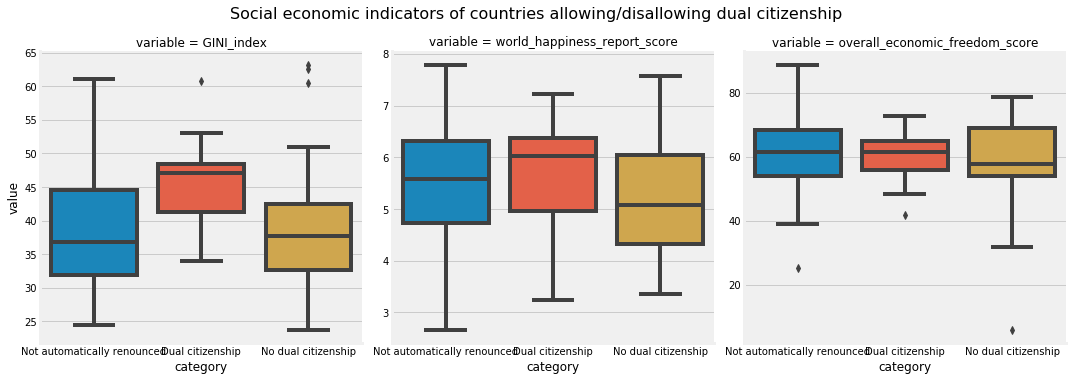

In [26]:
g=sns.catplot(x='category', y='value', col='variable', kind='box', data=dfs, sharey=False)
g.fig.suptitle('Social economic indicators of countries allowing/disallowing dual citizenship',y=1.05, size=16)

Based on these limited stats, countries allowing dual citizenship has higher happiness, overall economic freedom and Gini index (wealth inequality). More evidence is needed to figure out why these might be the case.

## Sources

Data source (extracted on Jan 10 2019):   
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/TTMZ08/NZM6Y4&version=3.0